In [1]:
import os
from pathlib import Path
# Check if the code is running on Google Colab
try:
    import google.colab
    IN_COLAB = True
    base_path = "/content/"
    if Path(f"{base_path}final_project").is_dir():
      %cd {base_path}final_project
      !git pull
      %cd {base_path}
    else:
      !git clone https://github.com/fernandaluft/final_project.git
except ImportError:
    IN_COLAB = False
    base_path = "/workspaces/"

Cloning into 'final_project'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 92 (delta 42), reused 66 (delta 19), pack-reused 0
Receiving objects: 100% (92/92), 726.00 KiB | 20.74 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from final_project.src.scraping import Scraping
import os
import plotly.express as px
from wordcloud import WordCloud

In [3]:
scraping = Scraping(IN_COLAB)
scraping.kaggle_scrape()

In [4]:
limit = 200000
dataset_limit=2000

In [5]:
class Eda():
    def __init__(self, limit, dataset_limit):
        self.dataset_limit = dataset_limit
        self.limit = limit
        os.makedirs(f'{base_path}final_project/charts', exist_ok=True)
        os.makedirs(f'{base_path}final_project/preprocessed_data', exist_ok=True)

    def merge_datasets(self):
        if self.limit != None:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv').sample(self.limit)
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv').sample(self.limit)
        else:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv')
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv')
        self.books_df = self.df1.merge(self.df2, left_on='Title', right_on='Title', how='inner')
        self.books_df = self.books_df.sample(self.dataset_limit)
        self.books_df.to_csv(f"{base_path}final_project/data/books_reviews.csv", index=False)
        os.system(f'zip -r {base_path}final_project/preprocessed_data/books_reviews.zip {base_path}final_project/data/books_reviews.csv')
        #os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.csv')
        command = "split -b 100M '{}' --additional-suffix=_{}".format(f'{base_path}final_project/preprocessed_data/books_reviews.zip', os.path.basename(f'{base_path}final_project/preprocessed_data/books_reviews.zip'))
        os.system(command)
        !mv {base_path}*_books_reviews.zip {base_path}final_project/preprocessed_data/
        os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.zip')

        return self.books_df

    def explore(self):
        self.books_df = pd.read_csv(f"{base_path}final_project/data/books_reviews.csv")
        print(f'Dataset Info:\n {self.books_df.info()}')
        print(f'Number of duplicates:\n {self.books_df.duplicated().sum()}')
        print(f'Null values:\n {self.books_df.isnull().sum()}')
        sns.heatmap(self.books_df.isnull(), annot = False)
        plt.savefig(f'{base_path}final_project/charts/heatmap_null_values.jpg')
        plt.show()
        print(self.books_df.head())
        print(self.books_df.Title.nunique())
        print(self.books_df.groupby('Title')['review/text'].count().sort_values(ascending=False).iloc[0:51])
        print(self.books_df.describe(include = np.number).T)
        print(self.books_df.describe(include = ['O']).T)

        plt.figure(figsize=(4,4))
        plt.title("Correlation Analysis of Amazon Books Reviews")
        corr = self.books_df.corr()
        sns.heatmap(corr, annot = True)
        plt.savefig(f'{base_path}final_project/charts/correlation_matrix.jpg')
        plt.show()

    def data_cleaning(self):
        self.books_df = self.books_df.drop_duplicates()
        self.books_df = self.books_df.reset_index(drop=True)
        print(f'New dataset shape:\n {self.books_df.shape}')
        print('Removing irrevelant variables...\n')
        self.books_df = self.books_df.drop(['previewLink', 'infoLink', 'Id', 'Price', 'User_id', 'profileName'], axis = 1)
        print(f'New dataset columns:\ {self.books_df.columns}')

    def univariate_variables(self):
        self.books_df_cat = self.books_df.select_dtypes(include=['O'])
        self.books_df_num = self.books_df.select_dtypes(include=np.number)
        print(f'Categorical and textual features:\n {self.books_df_cat.info()}')
        print(f'Numerical features:\n {self.books_df_num.info()}')

        '''fig, axis = plt.subplots(1, 3, figsize = (8,8))
        sns.countplot(ax = axis[0], data = self.books_df_cat, x = "publisher").set(xlabel = None)
        sns.countplot(ax = axis[1], data = self.books_df_cat, x = "categories").set(xlabel = None)
        sns.countplot(ax = axis[2], data = self.books_df_cat, x = "authors").set(xlabel = None)
        plt.tight_layout()
        plt.savefig(f'{base_path}final_project/charts/plot_categorical_variables.jpg')
        plt.show()'''
        #Bar plot of categories with a count above median
        cat_filter = self.books_df_cat['categories'].value_counts()[self.books_df_cat['categories'].value_counts() > self.books_df_cat.categories.value_counts().median()]
        plt.figure(figsize=(14,6))
        cat_filter.plot(kind='bar')
        plt.xticks(fontsize=9)
        plt.title('Books categories with a Count above the Median')
        plt.tight_layout()
        plt.savefig(f'{base_path}final_project/charts/barplot_categories.jpg')
        plt.show()

        #Wordcloud of categories
        wordcloud_categories = WordCloud(width=600, height=600, background_color="black", max_words=1000,
                                         min_font_size=20, random_state = 42).generate(str(self.books_df_cat['categories']))
        fig = plt.figure(figsize=(3,3))
        plt.title('Wordcloud of Categories')
        plt.imshow(wordcloud_categories)
        plt.axis('off')
        plt.savefig(f'{base_path}final_project/charts/wordcloud_categories.jpg')
        plt.show()

        #Wordcloud of review/summary
        wordcloud_summary = WordCloud(width=600, height=600, background_color="black", max_words=1000,
                                      min_font_size=20, random_state = 42).generate(str(self.books_df_cat['review/summary']))
        fig = plt.figure(figsize=(3,3))
        plt.title('Wordcloud of Review Summary')
        plt.imshow(wordcloud_summary)
        plt.axis('off')
        plt.savefig(f'{base_path}final_project/charts/wordcloud_summary.jpg')
        plt.show()

        #Histplot of numerical variables
        fig, axis = plt.subplots(1, 2)
        sns.histplot(ax = axis[0], data = self.books_df_num, x = "ratingsCount").set_xlim(0,250)
        sns.histplot(ax = axis[1], data = self.books_df_num, x = "review/score")
        plt.tight_layout()
        plt.savefig(f'{base_path}final_project/charts/plot_numerical_variables.jpg')
        plt.show()

    def bivariate_analysis(self):
      self.books_df_scatter = self.books_df.dropna(subset=["categories", "review/score", "ratingsCount"])
      fig = px.scatter(self.books_df_scatter, x="review/score", y="ratingsCount", color="categories",
                      size="ratingsCount", title="Scatter Plot for Book Ratings")
      fig.update_layout(title_text="Scatter Plot for Book Ratings", xaxis_title="Ratings", yaxis_title="Ratings Count")
      fig.show()



In [6]:
eda = Eda(limit, dataset_limit)

In [7]:
%%time
books_df = eda.merge_datasets()

CPU times: user 38.3 s, sys: 3.94 s, total: 42.3 s
Wall time: 42.4 s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               2000 non-null   object 
 1   description         1573 non-null   object 
 2   authors             1752 non-null   object 
 3   image               1643 non-null   object 
 4   previewLink         1790 non-null   object 
 5   publisher           1491 non-null   object 
 6   publishedDate       1772 non-null   object 
 7   infoLink            1790 non-null   object 
 8   categories          1633 non-null   object 
 9   ratingsCount        1093 non-null   float64
 10  Id                  2000 non-null   object 
 11  Price               302 non-null    float64
 12  User_id             1603 non-null   object 
 13  profileName         1603 non-null   object 
 14  review/helpfulness  2000 non-null   object 
 15  review/score        2000 non-null   float64
 16  review

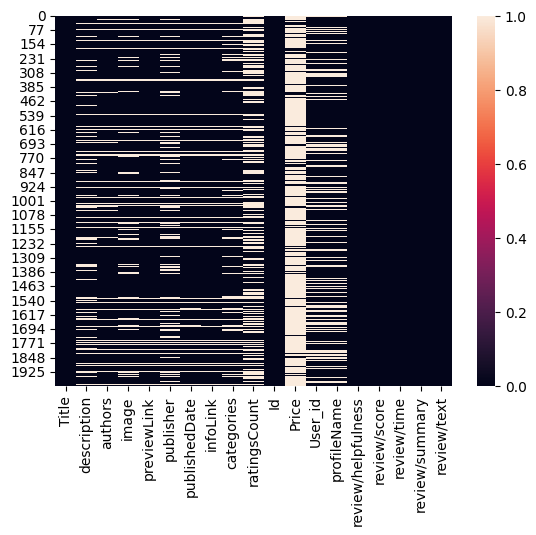

                                       Title  \
0              The Hound of the Baskervilles   
1              The sweet smell of Christmas,   
2  The Bone Collector (Lincoln Rhyme Novels)   
3                 Lord of the Flies, a Novel   
4                        The Nazi connection   

                                         description  \
0  When Sir Charles Baskerville dies suddenly fro...   
1  Six treated strips, disguised as part of an il...   
2  New York City is thrown into chaos by the assa...   
3  Nog altijd even opwindend en tot nadenken stem...   
4  When Hitler published Mein Kampf in 1924, he h...   

                      authors  \
0  ['Sir Arthur Conan Doyle']   
1      ['Patricia M. Scarry']   
2          ['Jeffery Deaver']   
3         ['William Golding']   
4             ['Stefan Kuhl']   

                                               image  \
0  http://books.google.com/books/content?id=hRfZD...   
1  http://books.google.com/books/content?id=0sG3C...   
2  http

<ipython-input-5-21fe4b875285>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = self.books_df.corr()


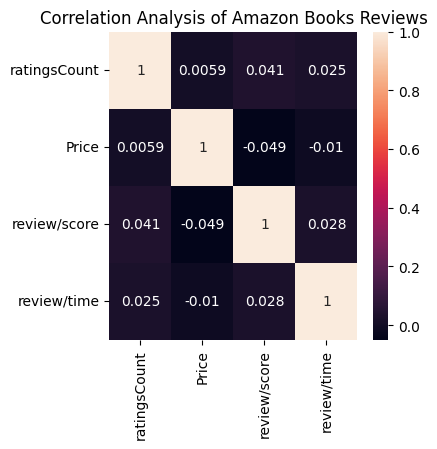

In [8]:
eda.explore()

In [9]:
eda.data_cleaning()

New dataset shape:
 (2000, 19)
Removing irrevelant variables...

New dataset columns:\ Index(['Title', 'description', 'authors', 'image', 'publisher',
       'publishedDate', 'categories', 'ratingsCount', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               2000 non-null   object
 1   description         1573 non-null   object
 2   authors             1752 non-null   object
 3   image               1643 non-null   object
 4   publisher           1491 non-null   object
 5   publishedDate       1772 non-null   object
 6   categories          1633 non-null   object
 7   review/helpfulness  2000 non-null   object
 8   review/summary      2000 non-null   object
 9   review/text         2000 non-null   object
dtypes: object(10)
memory usage: 156.4+ KB
Categorical and textual features:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ratingsCount  1093 non-null   float64

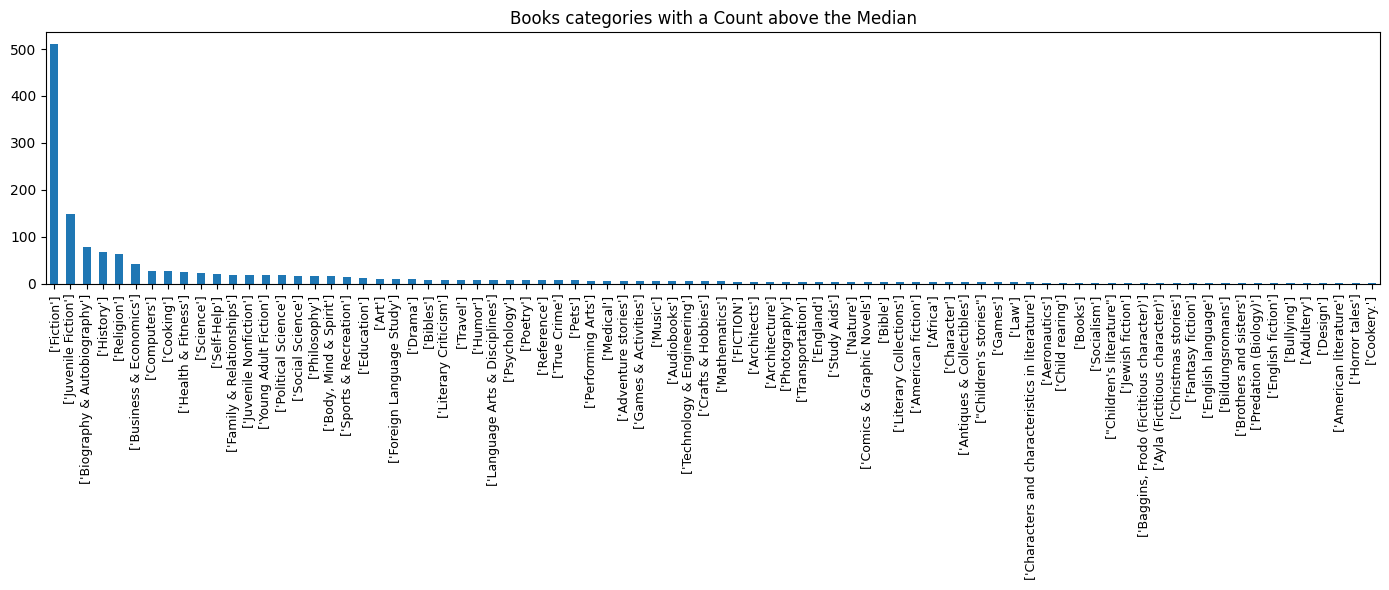

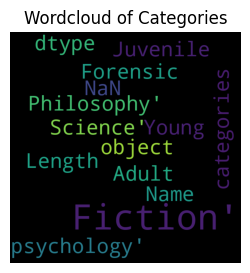

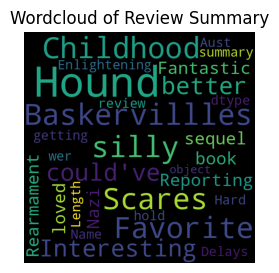

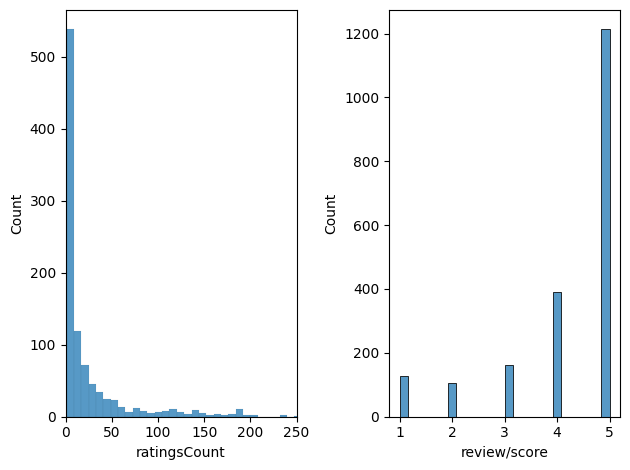

In [10]:
eda.univariate_variables()

In [11]:
eda.bivariate_analysis()

In [12]:
'''
%cd {base_path}final_project
!git config --global --unset credential.helper
#!git config --global user.name "fernandaluft"
#!git config --global user.email "fernandaluft@gmail.com"
#!git config --global user.name "neural1977"
#!git config --global user.email "pugliese05@gmail.com"
!git add .
!git commit -m "New Final Project"
'''

'\n%cd {base_path}final_project\n!git config --global --unset credential.helper\n#!git config --global user.name "fernandaluft"\n#!git config --global user.email "fernandaluft@gmail.com"\n#!git config --global user.name "neural1977"\n#!git config --global user.email "pugliese05@gmail.com"\n!git add .\n!git commit -m "New Final Project"\n'

In [13]:
#!git push origin main